In [28]:
import numpy as np
# from scipy import integrate
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVC
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import PrecisionRecallDisplay, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [33]:
new_df = pd.read_csv('../Data/167_features.csv')
new_df = new_df.loc[:, ~new_df.columns.str.contains('^Unnamed')]

In [34]:
x_list = list(new_df)
x_list = x_list[:-1]
# x_list

In [35]:
X = np.asarray(new_df[x_list])
Y = np.asarray(new_df['general_syntax#'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle= True)

In [16]:
(y_train[0])

5

In [5]:
lineReg = LinearRegression()
lineReg.fit(X_train, y_train)
print('Score: ', lineReg.score(X_test, y_test))
# print('Weights: ', lineReg.coef_)

Score:  0.15499177189303193


In [ ]:
svm_initial_model = pickle.load(open('../models/svm_initial_model.sav', 'rb'))
y_pred = svm_initial_model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5201169020944959


In [ ]:
svc_model2 = pickle.load(open('../models/poly_svc_model2.sav', 'rb'))

In [ ]:
y_pred = svc_model2.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8192888455918168


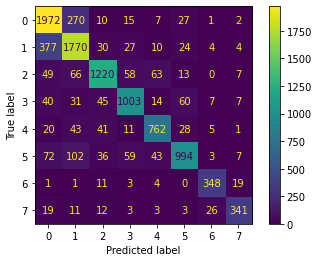

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=svc_model2.classes_)
disp.plot()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      2304
           1       0.77      0.79      0.78      2246
           2       0.87      0.83      0.85      1476
           3       0.85      0.83      0.84      1207
           4       0.84      0.84      0.84       911
           5       0.87      0.76      0.81      1316
           6       0.88      0.90      0.89       387
           7       0.88      0.82      0.85       418

    accuracy                           0.82     10265
   macro avg       0.84      0.83      0.83     10265
weighted avg       0.82      0.82      0.82     10265



# 10 classes 

In [6]:
svc_model3 = pickle.load(open('../models/poly_svc_model3.sav', 'rb'))

In [7]:
y_pred = svc_model3.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8172495879875481


In [8]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='rocket_r') # cmap='rocket_r'
    #plt.savefig(filename)
    plt.show()

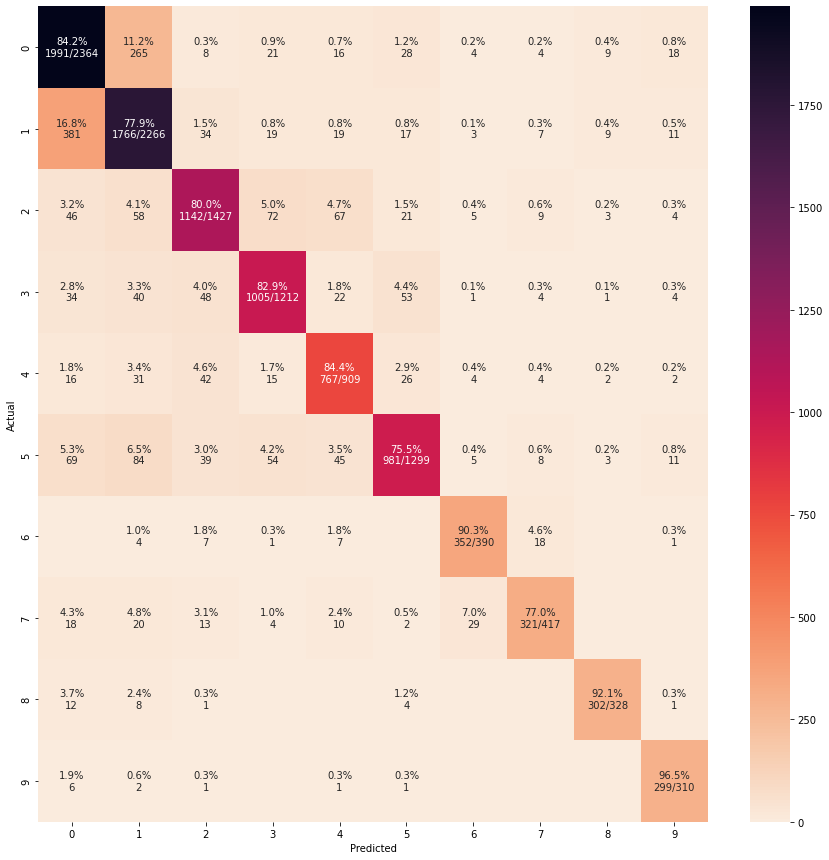

In [9]:
cm_analysis(y_test, y_pred, svc_model3.classes_, ymap=None, figsize=(15,15))

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.84      0.81      2364
           1       0.78      0.78      0.78      2266
           2       0.86      0.80      0.83      1427
           3       0.84      0.83      0.84      1212
           4       0.80      0.84      0.82       909
           5       0.87      0.76      0.81      1299
           6       0.87      0.90      0.89       390
           7       0.86      0.77      0.81       417
           8       0.92      0.92      0.92       328
           9       0.85      0.96      0.90       310

    accuracy                           0.82     10922
   macro avg       0.84      0.84      0.84     10922
weighted avg       0.82      0.82      0.82     10922



# Hypertuned Testing(improved ~92% accuracy)

In [37]:
# SVC(kernel='poly', degree=4, gamma='auto', coef0=1, C=10)
svc_model4 = pickle.load(open('../models/poly_svc_model4.sav', 'rb'))
y_pred = svc_model4.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.917780626258927


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2421
           1       0.89      0.91      0.90      2253
           2       0.92      0.92      0.92      1443
           3       0.93      0.91      0.92      1185
           4       0.90      0.91      0.91       832
           5       0.93      0.89      0.91      1315
           6       0.92      0.94      0.93       411
           7       0.93      0.90      0.91       394
           8       0.97      0.97      0.97       326
           9       0.96      0.94      0.95       342

    accuracy                           0.92     10922
   macro avg       0.93      0.92      0.92     10922
weighted avg       0.92      0.92      0.92     10922



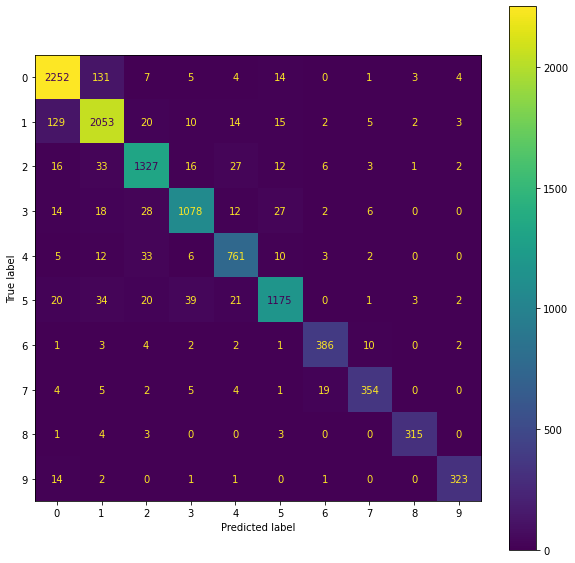

In [45]:
# cm_analysis(y_test, y_pred, svc_model4.classes_, ymap=None, figsize=(15,15))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=svc_model4.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'Class_Matrix.svg'

fig.savefig(image_name, format=image_format, dpi=1200)

In [15]:
X = X
y = Y
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y.shape[1]


# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svc_model4)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
model_filename = "My_class_model.sav"
saved_model = pickle.dump(classifier, open(model_filename,'wb'))

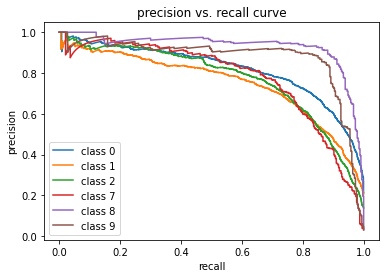

In [24]:
precision = dict()
recall = dict()
ls = [0,1,2,7,8,9]
for i in ls:
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i],  label='class {}'.format(i))

fig = plt
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
# plt.show()
image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'PR.svg'

fig.savefig(image_name, format=image_format, dpi=1200)